<a href="https://colab.research.google.com/github/kaljuvee/datascience/blob/master/notebooks/stats/regression_feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import statsmodels.api as sm
import numpy as np 
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.datasets import make_regression
import pandas as pd


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Background**

The simplest case of feature selection is the case where there are numerical input variables and a numerical target for regression predictive modeling, and this can often be done with statistical methods **correlation** and **mutual information**.


**Overview**

We demonstrate the following classical feature selection methods:

* **Correlation and mutual statistics** - evaluate the importance of numerical input data using the correlation 
and mutual information statistics.
* **Numerical feature selection** - perform feature selection for numerical input data when fitting and evaluating a regression model
* **Tuning with grid search** -  tune the number of features selected in a modeling pipeline using a grid search

**Model Pipeline**

1. Load and Convert Regression Dataset
2. Numerical Feature Selection
  1. Correlation Feature Selection
  2. Mutual Information Feature Selection
3. Modeling With Selected Features
  1. Model Built Using All Features
4. Tune the Number of Selected Features

**References**

* [Regression Feature Selection](https://machinelearningmastery.com/feature-selection-for-regression-data/)
* [scikit-learn](https://scikit-learn.org/)


**1. Load and Normalise Data Sets**

In [2]:
revenue_df = pd.read_csv('data/total_revenues_smartphone_sales_datetime.csv')
output_scaler = MinMaxScaler()
revenue_df['total_revenues'] = output_scaler.fit_transform(np.array(revenue_df['total_revenues']).reshape(-1, 1))
revenue_df.shape
# we expect 30 columns, excluding output variable and time index, and 37 quarterly data points

(37, 32)

In [3]:
revenue_df.head()

,Month,total_revenues,Alcatel,Apple,Asus,BlackBerry,Coolpad,Fujitsu,Gionee,HMD,HTC,Huawei,iTel,Lenovo,LG,Meizu,Micromax,Motorola,Nokia,Oppo,Others,Panasonic,Pantech,Samsung,Sharp,Sony,Tecno,Vivo,Wiko,Xiaomi,ZTE,Grand Total
0,3-2011,0.000000,0.02,18.6,0.20,13.8,1.60,1.4,0.7,0.0,9.60,2.3,0.0,1.0,4.1025,0.10,0.00,4.10,24.2,0.0,5.4982,0.05,0.43,12.5993,1.1,4.0,0.0,0.0,0.0,0.00,1.4,106.80
1,6-2011,0.023668,0.14,20.3,0.25,12.6,1.80,1.5,1.0,0.0,11.85,3.0,0.0,1.3,6.1995,0.10,0.00,4.40,16.7,0.0,6.7520,0.05,0.60,20.1985,1.0,4.4,0.0,0.0,0.0,0.00,2.5,116.64
2,9-2011,0.070400,0.35,17.1,0.25,11.7,2.15,1.2,1.3,0.0,13.15,4.8,0.0,1.7,4.4030,0.20,0.00,4.90,16.8,0.0,7.7655,0.10,0.85,28.1015,1.2,6.2,0.0,0.0,0.0,0.08,3.6,127.90
3,12-2011,0.065626,0.55,37.0,0.25,13.4,3.20,1.6,1.7,0.0,10.20,6.7,0.0,5.0,5.5020,0.25,0.00,5.30,19.6,0.0,8.0380,0.15,1.22,36.5000,1.2,6.4,0.0,0.0,0.0,0.40,5.4,169.56
4,3-2012,0.078637,0.70,35.1,0.30,9.9,3.80,2.6,1.8,0.0,6.70,4.7,0.0,4.7,4.9000,0.35,0.11,5.12,11.9,1.3,9.3200,0.20,1.30,44.4000,1.3,5.8,0.0,0.0,0.0,1.20,4.5,162.00


In [4]:
y_df = revenue_df['total_revenues']
y_df.head()

0    0.000000
1    0.023668
2    0.070400
3    0.065626
4    0.078637
Name: total_revenues, dtype: float64

In [5]:
# Select all features as regressors excluding target variable -  total revenues
X_df = revenue_df.loc[:, revenue_df.columns != 'total_revenues']
X_df.head()

,Month,Alcatel,Apple,Asus,BlackBerry,Coolpad,Fujitsu,Gionee,HMD,HTC,Huawei,iTel,Lenovo,LG,Meizu,Micromax,Motorola,Nokia,Oppo,Others,Panasonic,Pantech,Samsung,Sharp,Sony,Tecno,Vivo,Wiko,Xiaomi,ZTE,Grand Total
0,3-2011,0.02,18.6,0.20,13.8,1.60,1.4,0.7,0.0,9.60,2.3,0.0,1.0,4.1025,0.10,0.00,4.10,24.2,0.0,5.4982,0.05,0.43,12.5993,1.1,4.0,0.0,0.0,0.0,0.00,1.4,106.80
1,6-2011,0.14,20.3,0.25,12.6,1.80,1.5,1.0,0.0,11.85,3.0,0.0,1.3,6.1995,0.10,0.00,4.40,16.7,0.0,6.7520,0.05,0.60,20.1985,1.0,4.4,0.0,0.0,0.0,0.00,2.5,116.64
2,9-2011,0.35,17.1,0.25,11.7,2.15,1.2,1.3,0.0,13.15,4.8,0.0,1.7,4.4030,0.20,0.00,4.90,16.8,0.0,7.7655,0.10,0.85,28.1015,1.2,6.2,0.0,0.0,0.0,0.08,3.6,127.90
3,12-2011,0.55,37.0,0.25,13.4,3.20,1.6,1.7,0.0,10.20,6.7,0.0,5.0,5.5020,0.25,0.00,5.30,19.6,0.0,8.0380,0.15,1.22,36.5000,1.2,6.4,0.0,0.0,0.0,0.40,5.4,169.56
4,3-2012,0.70,35.1,0.30,9.9,3.80,2.6,1.8,0.0,6.70,4.7,0.0,4.7,4.9000,0.35,0.11,5.12,11.9,1.3,9.3200,0.20,1.30,44.4000,1.3,5.8,0.0,0.0,0.0,1.20,4.5,162.00


In [6]:
# Let's drop time index as as we are focusing on features only, not running the regression
X_df.drop('Month', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [7]:
from sklearn.model_selection import train_test_split
# split into train and test sets with 80% percent of the data for training and 20% percent for testing.
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=1)
# summarize
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (29, 30) (29,)
Test (8, 30) (8,)


**2. Numerical Feature Selection**

**2.1 Numerical Feature Selection - Correlation**

Feature 0: 4.629553
Feature 1: 19.392903
Feature 2: 24.631010
Feature 3: 66.997125
Feature 4: 4.814192
Feature 5: 39.063048
Feature 6: 0.012950
Feature 7: 21.346836
Feature 8: 99.770387
Feature 9: 99.585641
Feature 10: 32.951346
Feature 11: 3.092807
Feature 12: 4.346473
Feature 13: 15.555962
Feature 14: 1.114579
Feature 15: 30.315032
Feature 16: 46.791570
Feature 17: 82.701354
Feature 18: 71.218707
Feature 19: 4.129725
Feature 20: 40.862592
Feature 21: 13.722245
Feature 22: 0.658072
Feature 23: 10.360216
Feature 24: 114.705461
Feature 25: 80.100628
Feature 26: 17.486004
Feature 27: 89.883846
Feature 28: 0.276683
Feature 29: 82.142735


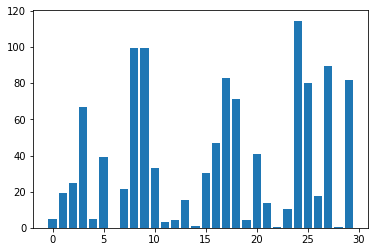

In [8]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from matplotlib import pyplot

# wrap feature selection logic in a function - use score_func=f_regression and select all features
def select_features_corr(X_train, y_train, X_test):
	# configure to select all features
	fs = SelectKBest(score_func=f_regression, k='all')
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

# feature selection using correlation, by default
X_train_fs, X_test_fs, fs = select_features_corr(X_train, y_train, X_test)

# what are scores for the features (ranging from less than 1 to 101)
def show_scores():
  for i in range(len(fs.scores_)):
	  print('Feature %d: %f' % (i, fs.scores_[i]))
  # plot the scores
  pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
  pyplot.show()

show_scores()

**Observation:**

* Huawei (9) and Samsung (24) show high scores
* Label the x axis or create a mapping dictionary

**2.2 Numerical Feature Selection - Mutual Information**

Feature 0: 0.641001
Feature 1: 0.366531
Feature 2: 0.403142
Feature 3: 0.880004
Feature 4: 0.551905
Feature 5: 0.484067
Feature 6: 0.816210
Feature 7: 0.408476
Feature 8: 0.684725
Feature 9: 1.229215
Feature 10: 0.451829
Feature 11: 0.404547
Feature 12: 0.606757
Feature 13: 0.663842
Feature 14: 0.476937
Feature 15: 0.399759
Feature 16: 0.746520
Feature 17: 0.917360
Feature 18: 0.903297
Feature 19: 0.281399
Feature 20: 0.905281
Feature 21: 0.325417
Feature 22: 0.000000
Feature 23: 0.596646
Feature 24: 0.868631
Feature 25: 0.932713
Feature 26: 0.545113
Feature 27: 0.890457
Feature 28: 0.489278
Feature 29: 0.992173


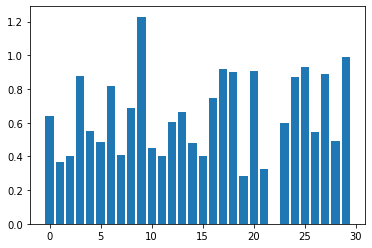

In [9]:
from sklearn.feature_selection import mutual_info_regression
# configure to select all features
# feature selection
def select_features_mutualinfo(X_train, y_train, X_test):
	# configure to select all features
	fs = SelectKBest(score_func=mutual_info_regression, k='all')
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

# feature selection using correlation
X_train_fs, X_test_fs, fs = select_features_mutualinfo(X_train, y_train, X_test)

show_scores()

**Observation:**

* Huawei (9) still scores high as important feature




**3. Modeling with Features**

**3.1 Using All Features**

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# fit the model
model = LinearRegression()
model.fit(X_train, y_train)
# evaluate the model
yhat = model.predict(X_test)
# evaluate predictions
mae = mean_absolute_error(y_test, yhat)
print('MAE: %.3f' % mae)

MAE: 0.549


**Observation:**

* Using all features we get Mean Absolute Error (MAE) of 0.549

**4. Tune the Number of Selected Features**

>11 -0.084 (0.033)
>12 -0.084 (0.033)
>13 -0.089 (0.033)
>14 -0.095 (0.038)
>15 -0.102 (0.040)
>16 -0.105 (0.039)
>17 -0.106 (0.042)
>18 -0.112 (0.043)
>19 -0.114 (0.043)
>20 -0.123 (0.045)
>21 -0.130 (0.047)
>22 -0.138 (0.048)
>23 -0.142 (0.052)
>24 -0.148 (0.065)
>25 -0.175 (0.099)
>26 -0.193 (0.095)
>27 -0.219 (0.097)
>28 -0.234 (0.113)
>29 -0.267 (0.121)
>30 -0.305 (0.332)


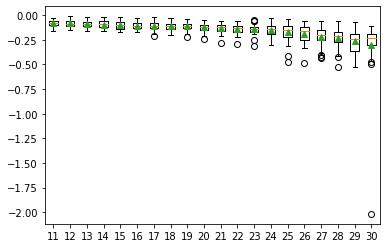

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

num_features = [i for i in range(X_df.shape[1]-19, X_df.shape[1]+1)]
# enumerate each number of features
results = list()
for k in num_features:
	# create pipeline
	model = LinearRegression()
	fs = SelectKBest(score_func=mutual_info_regression, k=k)
	pipeline = Pipeline(steps=[('sel',fs), ('lr', model)])
	# evaluate the model
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(pipeline, X_df, y_df, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
	results.append(scores)
	# summarize the results
	print('>%d %.3f (%.3f)' % (k, np.mean(scores), np.std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=num_features, showmeans=True)
pyplot.show()

**Resources**

* [Rergression Features Selection](https://machinelearningmastery.com/feature-selection-for-regression-data/) by Jason Brownlee